# PV Power Simulator
This notebook is intended to take solar irradiance data and a model for system behaviour as inputs, and perform an analysis that gives the tank water level at any point in time over the course of a year.

In [1]:
## Install Dependencies

# import sys
# !conda install --yes -c pvlib pvlib
# !conda install --yes -c conda-forge ipympl

# %pip install pvlib
#!conda config --env --append channels nrel
#!conda install nrel-pysam nrel-pysam-stubs
#%pip install NREL-PySAM

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
from Solar import WaterSystem, PV_Panel, SysBehavior, SysState, PV_Params
from dataclasses import dataclass
import pvlib

## Define the system parameters

In [3]:
#Set for El Llanito, Nicaragua
latitude = 12.165512
longitude = -85.502874

altitude = 140 #From Google Maps
pv_tilt_angle = 14

#Best guess using datasheet: http://www.solarhub.com/product-catalog/pv-modules/32733-PM300P00-285-AU-Optronics
cell_parameters = PV_Params(
    length=1961.0,
    width=995.0,
    celltype='polySi',
    STC=224.99,
    PTC=203.3,
    V_MP=36.86,
    I_MP=7.96,
    V_OC=43.92,
    I_SC=8.53,
    ALPHA_SC=0.063 * 8.53 / 100,
    BETA_VOC=-0.332 * 43.92 / 100,
    GAMMA_PMP=-0.435,
    NSERIES=100,       #This is probably wrong. I need a photo of the panels
    TEMP_REF=45,
)

In [4]:
#Instantiate a system for solar-only simulations
dut_pvonly = WaterSystem(
    SysBehavior.only_solar, 
    SysState(0, 0, 6600/2, 0, 0, 0),
    6600, 
    PV_Panel(pv_tilt_angle, cell_parameters),
    1
)

## View the Solar Data


In [5]:
#Get some weather data
weather = pvlib.iotools.get_pvgis_tmy(latitude, 
                                      longitude, 
                                      map_variables=True)[0]

#Calculate Solar Panel Output Power for this weather
solar_data = dut_pvonly.panel.power_calc(weather, latitude, longitude, altitude)
solar_time = np.arange(0,365,1/24)

#Modify output for conversion efficiency loss
dut_pvonly.calc_loss(solar_data)

<IPython.core.display.Javascript object>


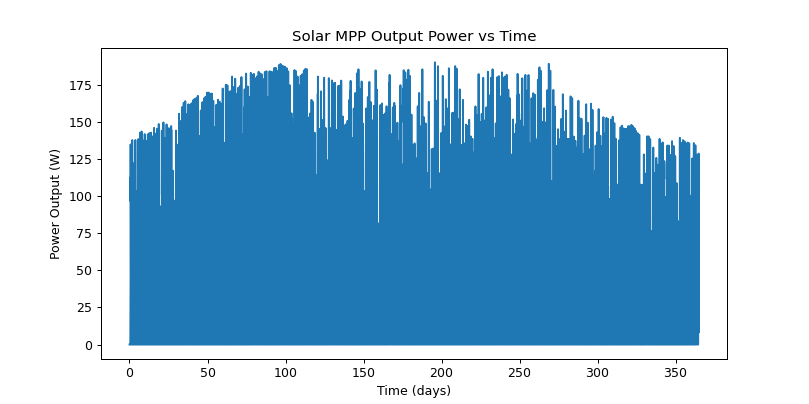

In [6]:
#Plot the data
solar_data_chart = plt.figure(figsize=(10,5))
plt.plot(solar_time, solar_data['p_mp'])
# plt.plot(solar_time, solar_data['v_oc'])
plt.title("Solar MPP Output Power vs Time")
plt.xlabel("Time (days)")
plt.ylabel("Power Output (W)")
plt.show()

## Approximate Power-Pump Rate Curve

Using this figure from the SubDrive Solar datasheet from Franklin Electric: ![SolarPAK Performance Curve](SolarPAK-Performance.png "SolarPAK Performance Curve")

<IPython.core.display.Javascript object>


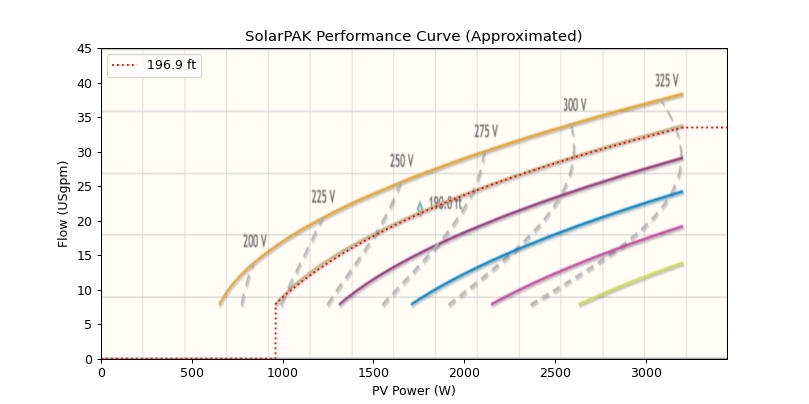

In [7]:
#The calc_flowrate function is implemented in the SysBehavior class, but a version of it is given below for use here

def calc_flowrate(power):
    exp = 0.25
    xofs = -500
    r1 = (33.5 - 7.9523)
    r2 = (np.power(3203.16 + xofs, exp) - np.power(961.708 + xofs, exp))
    ofs = np.power(961.708 + xofs, exp) * r1/r2
    interpolated = np.power(np.maximum(1, power + xofs), exp) * r1/r2 + 7.9523 - ofs
    return np.minimum(interpolated * (power > 961.708), 33.5)

img = mpimg.imread('SolarPAK-Performance.png')
fr_power_plt = plt.figure(figsize=(10,5))
plt.imshow(img, aspect='auto', extent=(0, 3450, 0, 45))

input_powers = np.arange(0, 3450)
plt.plot(input_powers, calc_flowrate(input_powers), 'r:') #don't need time for only_solar
plt.title("SolarPAK Performance Curve (Approximated)")
plt.xlabel("PV Power (W)")
plt.ylabel("Flow (USgpm)")
plt.legend(["196.9 ft"], loc='upper left')
plt.show()

## Model the Water Consumption of the Community

From Phil: We have the assumption that the peak water demand is in the morning.  I’ll have to hunt down the exact numbers, but it’s something like 30% of water usage is expected between 6 am and 9 am and the rest is spread out until, say, 7 pm when it tapers off for the night.

### Daily Water Use

<IPython.core.display.Javascript object>


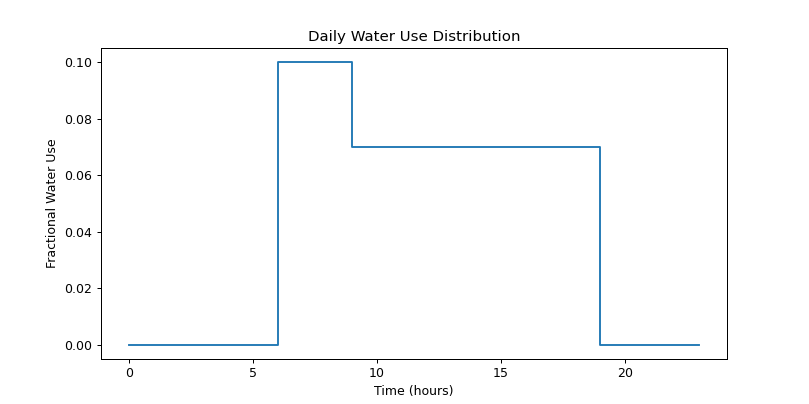

In [8]:
#30% of total water usage is from hours 6-9, then the other 70% is from 9-19. Note, the array is in UTC time
daily_usage = np.array([
    0.07, #18
    0,    #19
    0,    #20
    0,    #21
    0,    #22
    0,    #23
    0,    #0
    0,    #1
    0,    #2
    0,    #3
    0,    #4
    0,    #5
    0.1,  #6
    0.1,  #7
    0.1,  #8
    0.07, #9
    0.07, #10
    0.07, #11
    0.07, #12
    0.07, #13
    0.07, #14
    0.07, #15
    0.07, #16
    0.07  #17
])

times = np.arange(0,24)

daily_water_use = plt.figure(figsize = (10,5))
plt.step(times, np.roll(daily_usage, -6), where='post') #roll to convert from UTC
plt.title("Daily Water Use Distribution")
plt.xlabel("Time (hours)")
plt.ylabel("Fractional Water Use")
plt.show()

### Monthly Water Use (Including Houly Data from Above)

Susan's Data:

|Time Period |Volume / Day (USg) |
| :--- | ---: |
| 6/10 - 7/10 | 4326.77 |
| 7/11 - 8/10 | 3780.57 |
| 8/11 - 9/10 | 4434.54 |
| 9/11 - 10/10 | 3402.39 |
| 10/11 - 11/10 | 4385.88 |
| 11/11 - 12/10 | 2947.46 |
| 12/11 - 1/10 | 4648.52 |

<IPython.core.display.Javascript object>


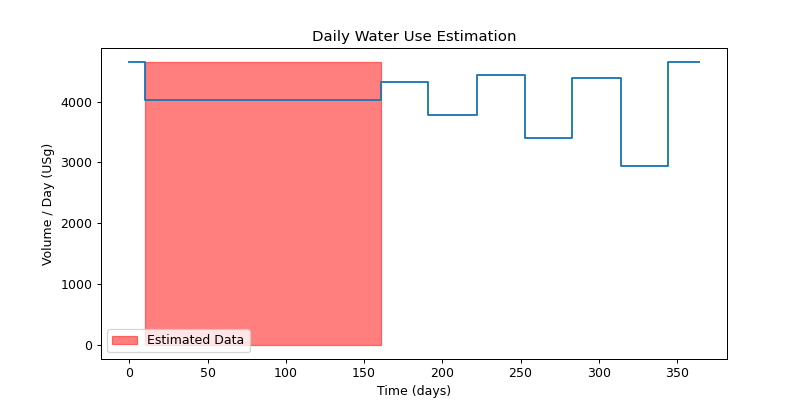

In [9]:
year_usage_data = np.array([
    [0, 4648.52],    #January 1 - January 10
    [10, 0],         #January 11 - February 10
    [41, 0],         #February 11 - March 10
    [69, 0],         #March 11 - April 10
    [100, 0],        #April 11 - May 10
    [130, 0],        #May 11 - June 10
    [161, 4326.77],  #June 11 - July 10
    [191, 3780.57],  #July 11 - August 10
    [222, 4434.54],  #August 11 - September 10
    [253, 3402.39],  #September 11 - October 10
    [283, 4385.88],  #October 11 - November 10
    [314, 2947.46],  #November 11 - December 10
    [344, 4648.52],  #December 11 - December 31
    [364, 4648.52]     #required for nice display
])

numdays = [10, 0, 0, 0, 0, 0, 30, 31, 31, 30, 31, 30, 31, 0]
estimation = np.sum(year_usage_data[:,1] * numdays)/np.sum(numdays)

#Fill in the estimated usage data
year_usage_data = np.array([
    [0, 4648.52],    #January 1 - January 10
    [10, estimation],         #January 11 - February 10
    [41, estimation],         #February 11 - March 10
    [69, estimation],         #March 11 - April 10
    [100, estimation],        #April 11 - May 10
    [130, estimation],        #May 11 - June 10
    [161, 4326.77],  #June 11 - July 10
    [191, 3780.57],  #July 11 - August 10
    [222, 4434.54],  #August 11 - September 10
    [253, 3402.39],  #September 11 - October 10`
    [283, 4385.88],  #October 11 - November 10
    [314, 2947.46],  #November 11 - December 10
    [344, 4648.52],  #December 11 - December 31
    [364, 4648.52]     #required for nice display
])

monthly_water_use = plt.figure(figsize = (10,5))
plt.step(year_usage_data[:,0], year_usage_data[:,1], where='post')
nodata = plt.fill_between([10, 161], np.max(year_usage_data[:,1]), alpha=0.5, color='red')
plt.title("Daily Water Use Estimation")
plt.xlabel("Time (days)")
plt.ylabel("Volume / Day (USg)")
plt.legend([nodata], ["Estimated Data"])
plt.show()

<IPython.core.display.Javascript object>


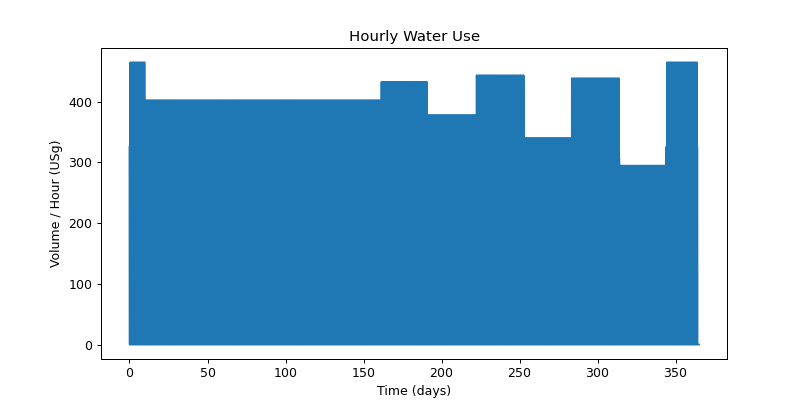

In [10]:
#Estimate hourly usage over the year

hourly_usage = np.zeros(365 * 24)
for idx in range(1, len(year_usage_data)):
    hourly_usage[24 * int(year_usage_data[idx - 1,0]):24 * int(year_usage_data[idx,0])] = (
        year_usage_data[idx - 1,1] * np.tile(daily_usage, int(year_usage_data[idx,0] - year_usage_data[idx - 1,0])))
    
hourly_usage_fig = plt.figure(figsize=(10,5))
plt.plot(solar_time, hourly_usage)
plt.title("Hourly Water Use")
plt.xlabel("Time (days)")
plt.ylabel("Volume / Hour (USg)")
plt.show()

## Calculate the PV-Only Flow Rate vs Time for Different Numbers of Panels

<IPython.core.display.Javascript object>


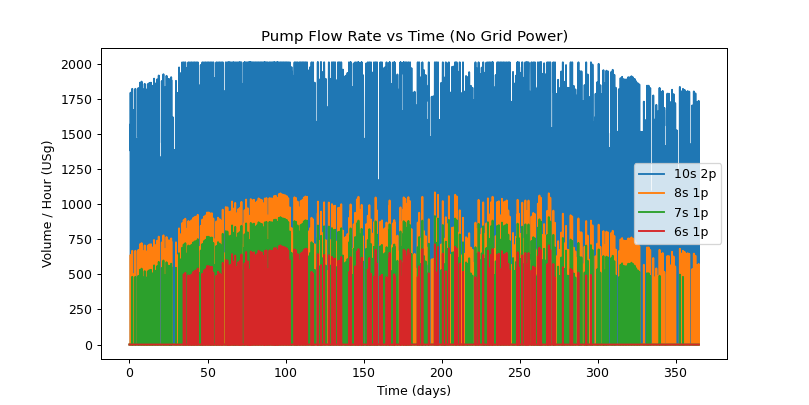

In [21]:
comparison_plt = plt.figure(figsize=(10,5))

numpanels = [20, 8, 7, 6]
for panels in numpanels:
    plt.plot(solar_time, calc_flowrate(panels * solar_data['p_mp']) * 60)

plt.title("Pump Flow Rate vs Time (No Grid Power)")
plt.xlabel("Time (days)")
plt.ylabel("Volume / Hour (USg)")
plt.legend(["10s 2p", "8s 1p", "7s 1p", "6s 1p"])
plt.show()

<IPython.core.display.Javascript object>


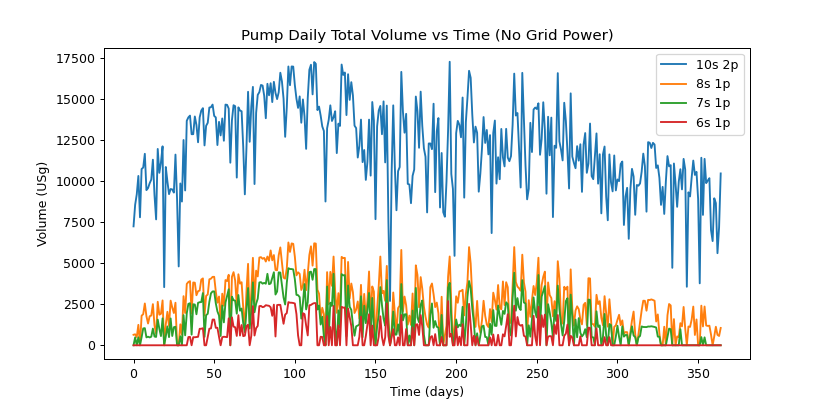

In [22]:
#Plot daily water level
daily_wl = plt.figure(figsize=(10,5))

for panels in numpanels:
    raw = calc_flowrate(panels * solar_data['p_mp']) * 60

    daily_flow = np.zeros(int(len(raw)/24))
    for i in range(len(raw)):
        daily_flow[int(i / 24)] += raw[i]

    plt.plot(daily_flow)
    
plt.title("Pump Daily Total Volume vs Time (No Grid Power)")
plt.xlabel("Time (days)")
plt.ylabel("Volume (USg)")
plt.legend(["10s 2p", "8s 1p", "7s 1p", "6s 1p"])
plt.show()

## Simulate Complex Behaviors

In [12]:
#Takes a WaterSystem Object, returns an np.array of water level vs time
def sim(sys, weather, latitude, longitude, altitude, use):
    
    #Calculate the weather data
    solar_data = sys.panel.power_calc(weather, latitude, longitude, altitude)
    sys.calc_loss(solar_data)
    
    #create the output arrays
    tank_levels = np.zeros(len(solar_data["p_mp"]))
    grid_power = np.zeros(len(solar_data["p_mp"]))
    pump_rates = np.zeros(len(solar_data["p_mp"]))
    
    for time_idx in range(len(solar_data["p_mp"])):
        #copy over the data
        tank_levels[time_idx] = sys.state.tank_level
        grid_power[time_idx] = sys.state.grid_power
        pump_rates[time_idx] = sys.state.pump_rate

        sys.step(use[time_idx], solar_data["p_mp"][time_idx])

    return np.stack((np.arange(0, 365, 1/24), tank_levels, grid_power, pump_rates, solar_data["p_mp"]), axis=0)

In [13]:
#Instantiate a system for solar-only simulations
dut_complex = WaterSystem(
    SysBehavior.solar_grid_time_window, 
    SysState(0, 0, 6600/2, 0, 0, 0), 
    6600, 
    PV_Panel(pv_tilt_angle, cell_parameters),
    7
)

#Run the simulation
output = sim(dut_complex, weather, latitude, longitude, altitude, hourly_usage)

<IPython.core.display.Javascript object>


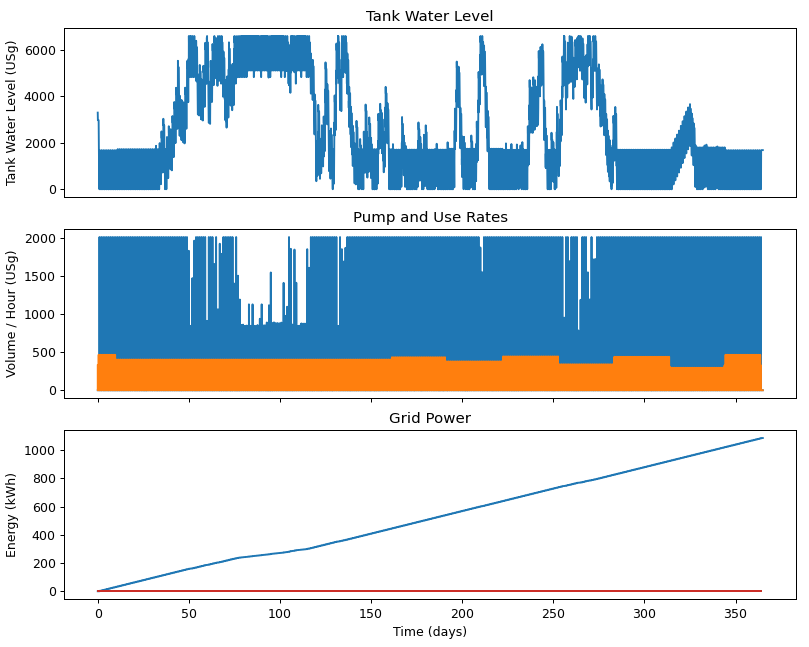

In [14]:
cfig, axs = plt.subplots(3,1,figsize=(10,8), sharex=True)

axs[0].set_title("Tank Water Level")
axs[0].plot(output[0], output[1])
plt.xlabel("Time (days)")
axs[0].set_ylabel("Tank Water Level (USg)")
axs[0].xaxis.set_visible(False)

axs[1].set_title("Pump and Use Rates")
axs[1].step(output[0], output[3])
axs[1].step(output[0], hourly_usage)
axs[1].set_ylabel("Volume / Hour (USg)")

axs[2].set_title("Grid Power")
axs[2].plot(output[0], output[2]/1000)
axs[2].set_ylabel("Energy (kWh)")

plt.tight_layout()
plt.show()